In [16]:
import numpy as np
import matplotlib.pyplot as plt
import bagpipes as pipes
from PyAstronomy import pyasl
from astropy.cosmology import FlatLambdaCDM
import json
cosmo = FlatLambdaCDM(H0=70., Om0=0.3)

import sys
sys.path.append('../..')
# load in LHa functions used to calculate EW(Ha)
from code_bits import H_alpha
# used to calculate the pseudo-continuum in Halpha
from mangadap.proc.bandpassfilter import pseudocontinuum

## Calculating spectral features with bagpipes from mocks
Bagpipes has built in features to return the spectral indices based on user-defined passbands (the bagpipes read the docs are not updated with documentation for this yet). We can use those for absorption lines. However, for emission lines, it is a bit more tricky. Here are two methods:
1. Count the number of ionizing photons bluewards of the Lyman break from a mock spectrum generated from Bagpipes (must be no dust!), then convert that to $H_\alpha$ luminosity through SFR conversions in Kennicutt & Evans 2012 (based on Murphy et al. 2011). Then divide it by the pseudo continuum constructed around $H_\alpha$.
2. Generate a mock spectrum with nebular emission with Bagpipes, and another one based on identical properties but no nebular component. Take the difference between the two spectra at $H_\alpha$, then divide it by the pseudo continuum constructed around $H_\alpha$ from the no nebular mock.

In this notebook, I will first demonstrate how to get the absorption index HdeltaA, then the two methods to get EW(Ha).

### Define some spectral index passbands in a dictionary, then compile to an index list

In [28]:
# bandpass definitions from Worthey & Ottavani 1997 
# https://ui.adsabs.harvard.edu/abs/1997ApJS..111..377W/abstract
# medium = air
HdeltaA = {}
HdeltaA["name"] = "HdeltaA"
HdeltaA["type"] = "EW"
HdeltaA["continuum"] = [[4041.60, 4079.75], [4128.50, 4161.00]]          # blue bandpass, red bandpass
HdeltaA["feature"] = [4083.50, 4122.25]

# bandpass definitions from MaNGA DAP
# https://ui.adsabs.harvard.edu/abs/2019AJ....158..231W/abstract
# medium = vacuum, need to convert to air
Halpha = {}
Halpha["name"] = "Halpha"
Halpha["type"] = "EW"
Halpha["continuum"] = [pyasl.vactoair2([6483.0, 6513.0]), pyasl.vactoair2([6623.0, 6653.0])]
Halpha["feature"] = pyasl.vactoair2([6557.6, 6571.6])

index_list = [HdeltaA, Halpha]

# we also define the wavelength of the actual line, also from MaNGA DAP
lambda_Halpha = pyasl.vactoair2(6564.632)

### Make a simple mock spectrum with exponential decay SFH and some dust, then we can use Bagpipes to directly find the absorption spectral index

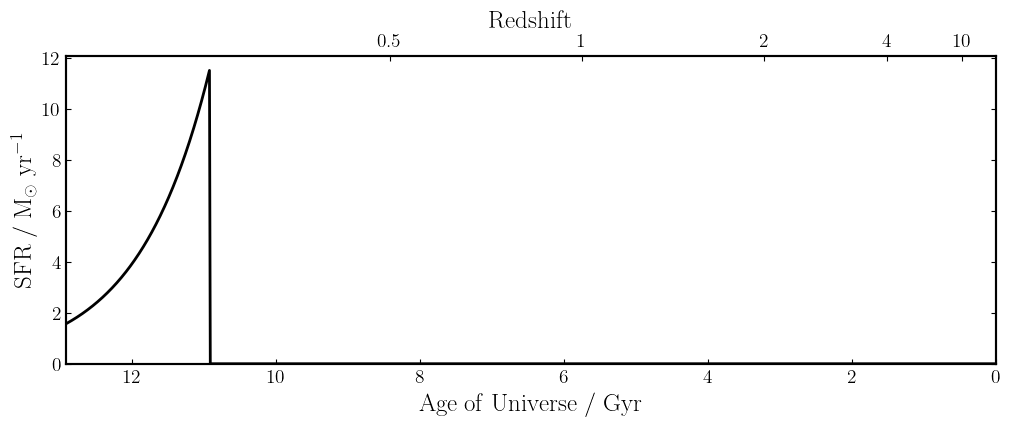

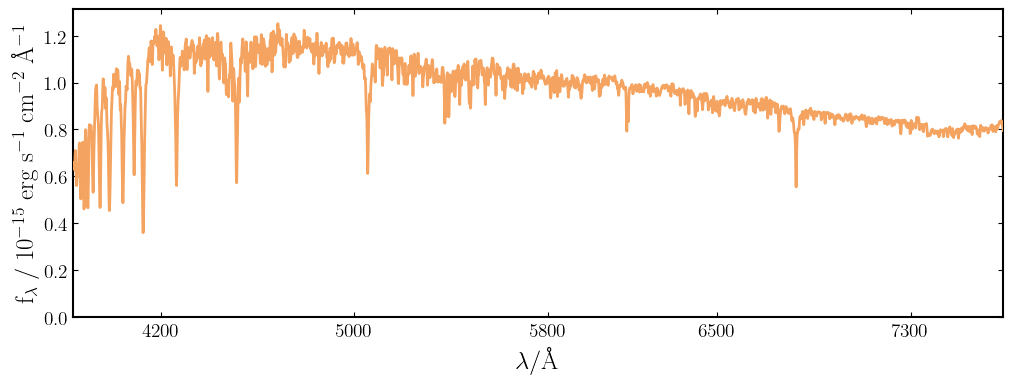

HdeltaA index = 6.06554334348383


In [60]:
# Make a simple exponential model with some dust
exp = {}
exp['massformed'] = 10
exp['metallicity'] = 1.0
exp['age'] = 2.0
exp['tau'] = 1.0

dust = {}
dust['type'] = 'VW07'
dust['Av'] = 0.6
dust['eta'] = 3.0

model_comp = {}
model_comp['exponential'] = exp
model_comp['dust'] = dust
model_comp['t_bc'] = 0.01
model_comp['redshift'] = 0.04

# instead of passing bagpipes model_galaxy a list of filters or wavelengths, we pass it the index list
dusty_model = pipes.model_galaxy(model_comp, index_list=index_list)
dusty_model.sfh.plot()
dusty_model.plot()

# extract index
print(f'HdeltaA index = {dusty_model.indices[0]}')

### Method 1 of measuring EW(Ha)
Steps:
1. Generate a new model with identical properties but without dust bluewards of the Lyman break
2. Shift Lyman spectrum to be in rest frame
3. Count Q0 with the new Lyman model
4. Convert to LHa through SFR
5. Apply dust attenuation to LHa
6. Measure the pseudo-continuum from the dusty model
7. EW(Ha) = LHa/continuum

### Generate a new model identical properties but without dust bluewards of the Lyman break

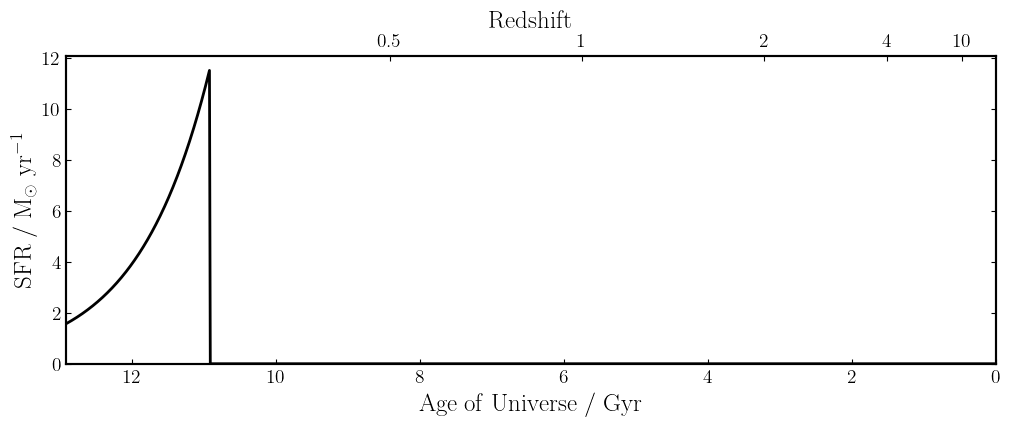

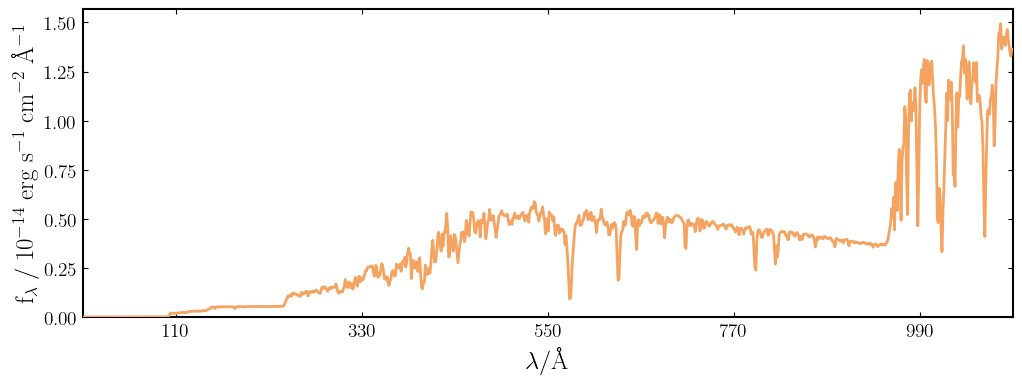

(<Figure size 1200x400 with 1 Axes>,
 [<AxesSubplot:xlabel='$\\lambda / \\mathrm{\\AA}$', ylabel='$\\mathrm{f_{\\lambda}}\\ \\mathrm{/\\ 10^{-14}\\ erg\\ s^{-1}\\ cm^{-2}\\ \\AA^{-1}}$'>])

In [61]:
model_comp = {}
model_comp['exponential'] = exp
model_comp['redshift'] = 0.04

obs_waves = np.linspace(0,1100,1000)

model_Q0 = pipes.model_galaxy(model_comp, spec_wavs = obs_waves)
model_Q0.sfh.plot()
model_Q0.plot()

### EW(Ha) calculation function

In [62]:
def get_Ha_continuum(model, Halpha_blue, Halpha_red, lambda_Halpha, z):
    # get pseudo continuum
    rest_wave = model.spectrum[:,0]/(1+z)
    rest_flux = model.spectrum[:,1]*(1+z)
    # pseudocontinuum function from MaNGA DAP package
    sidebands = pseudocontinuum(
        rest_wave, rest_flux, 
        passband=[Halpha_blue,Halpha_red], log=False
    )
    Halpha_continuum = ((sidebands[1][1] - sidebands[1][0]) * (lambda_Halpha - sidebands[0][0]) / 
                        (sidebands[0][1] - sidebands[0][0]) + sidebands[1][0])
    
    return Halpha_continuum

def cal_Ha_conversion(model_Q0, dusty_model, Halpha_bandpasses, lambda_Halpha, return_factors=False):
    
    z = dusty_model.model_comp['redshift']
    
    # shift to rest frame
    rest_wave_Q0 = model_Q0.spectrum[:,0]/(1+z)
    rest_flux_Q0 = model_Q0.spectrum[:,1]*(1+z)
    
    # convert to LHa
    #LHa = L_H_alpha(rest_wave, rest_flux)
    LHa = H_alpha.L_H_alpha2011(rest_wave_Q0, rest_flux_Q0, dusted=False)
    
    # attenuate LHa
    if 'dust' in dusty_model.model_comp:
        dust_dict = dusty_model.model_comp['dust']
        Av = dust_dict['Av']
        eta = dust_dict['eta']
        if dust_dict['type'] == 'VW07':
            A_ISM = Av*(5500/lambda_Halpha)**0.7   # ISM component
            A_BC = (eta-1)*Av*(5500/lambda_Halpha)**1.3    # birth cloud component
            LHa = LHa*10**(-(A_ISM+A_BC)/2.5)
        else:
            raise ValueError(f"Unrecognized dust type {dust_dict['type']}")
    
    # get pseudo continuum
    Halpha_continuum = get_Ha_continuum(dusty_model, 
                                        Halpha_bandpasses['continuum'][0], 
                                        Halpha_bandpasses['continuum'][1],
                                        lambda_Halpha,
                                        z
                                       )

    EW_Ha = LHa/Halpha_continuum
    
    if return_factors:
        return EW_Ha, LHa, Halpha_continuum
    
    return EW_Ha

In [63]:
print('EW Ha is')
print(cal_Ha_conversion(model_Q0, dusty_model, Halpha, lambda_Halpha))

EW Ha is
31.8581599602


### Method 2 of measuring EW(Ha)
Steps:
1. Generate a new model with identical properties with dust but with nebular emission, wavelength range only around Halpha
2. Meausre LHa flux by difference between nebular mock spectrum and no nebular mock spectrum OR get LHa from nebular model's CLOUDY outputs
3. Measure the pseudo-continuum from the dusty model
4. EW(Ha) = LHa/continuum

### Generate a new model with identical properties with dust but with nebular emission, wavelength range only around Halpha

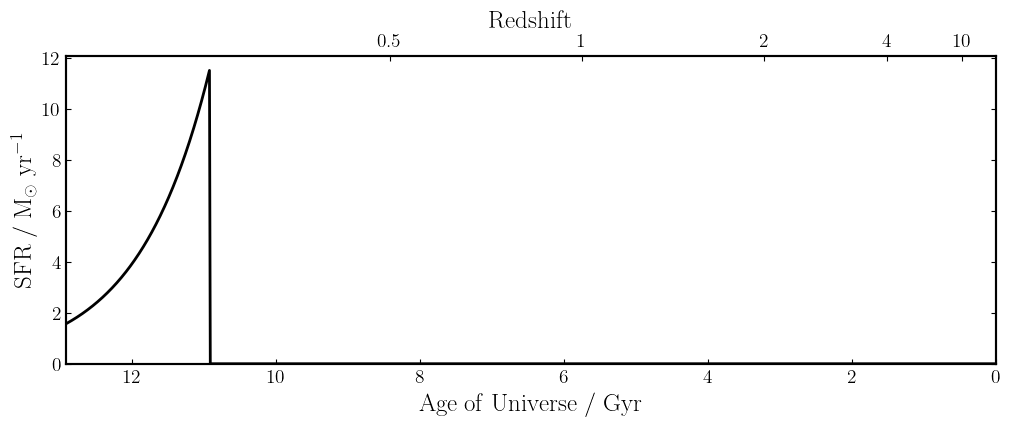

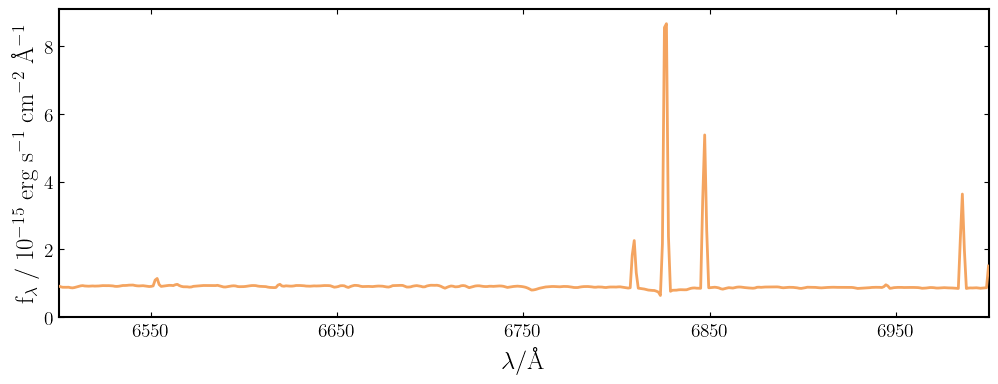

(<Figure size 1200x400 with 1 Axes>,
 [<AxesSubplot:xlabel='$\\lambda / \\mathrm{\\AA}$', ylabel='$\\mathrm{f_{\\lambda}}\\ \\mathrm{/\\ 10^{-15}\\ erg\\ s^{-1}\\ cm^{-2}\\ \\AA^{-1}}$'>])

In [64]:
nebular = {}
nebular['logU'] = -3

model_comp = {}
model_comp['exponential'] = exp
model_comp['dust'] = dust
model_comp['nebular'] = nebular
model_comp['t_bc'] = 0.01
model_comp['redshift'] = 0.04

Halpha_wave_lims = [6500, 7000]

obs_waves = dusty_model.spectrum[:,0][(dusty_model.spectrum[:,0]>Halpha_wave_lims[0]) & 
                                      (dusty_model.spectrum[:,0]<Halpha_wave_lims[1])]

nebular_model = pipes.model_galaxy(model_comp, spec_wavs = obs_waves)
nebular_model.sfh.plot()
nebular_model.plot()

### EW(Ha) calculation function

In [65]:
def cal_Ha_bagpipes(nebular_model, dusty_model, Halpha_bandpasses, lambda_Halpha, mode='measure', 
                    return_factors=False):
    
    z = dusty_model.model_comp['redshift']
    
    if mode == 'measure':
        # Meausre LHa flux by difference between nebular mock spectrum and no nebular mock spectrum
        # mask for only the feature portion in rest frame
        obs_mask_lims = [Halpha_bandpasses['feature'][0]*(1+z), Halpha_bandpasses['feature'][1]*(1+z)]

        # integrate for total flux of nebular spectrum in rest frame
        nebular_mask = ((nebular_model.spectrum[:,0]>obs_mask_lims[0]) & 
                        (nebular_model.spectrum[:,0]<obs_mask_lims[1]))
        nebular_wave = nebular_model.spectrum[nebular_mask,0]/(1+z)
        nebular_flux = nebular_model.spectrum[nebular_mask,1]*(1+z)
        nebular_total_flux = np.trapz(x=nebular_wave, y=nebular_flux)

        # integrate for total flux of dusty spectrum in rest frame
        dusty_mask = ((dusty_model.spectrum[:,0]>obs_mask_lims[0]) & 
                      (dusty_model.spectrum[:,0]<obs_mask_lims[1]))
        dusty_wave = dusty_model.spectrum[dusty_mask,0]/(1+z)
        dusty_flux = dusty_model.spectrum[dusty_mask,1]*(1+z)
        dusty_total_flux = np.trapz(x=dusty_wave, y=dusty_flux)

        LHa = nebular_total_flux - dusty_total_flux
        
    elif mode == 'cloudy':
        # Get LHa flux directly out of cloudy outputs saved by bagpipes in the model_galaxy object. The output
        # is already dust attenuated and in unit urg/s/cm^2
        LHa = nebular_model.line_fluxes['H  1  6562.81A']
    
    # get pseudo continuum
    Halpha_continuum = get_Ha_continuum(dusty_model, 
                                        Halpha_bandpasses['continuum'][0], 
                                        Halpha_bandpasses['continuum'][1],
                                        lambda_Halpha,
                                        z
                                       )

    EW_Ha = LHa/Halpha_continuum
    
    # set EW Ha vals that are slightly negative to 0, since they are most likely just integration differences
    if EW_Ha<0 and EW_Ha>-1:
        EW_Ha = 0
    
    if return_factors:
        return EW_Ha, LHa, Halpha_continuum
    
    return EW_Ha

In [66]:
print('EW Ha is')
print(cal_Ha_bagpipes(nebular_model, dusty_model, Halpha, lambda_Halpha, mode='measure'))
print(cal_Ha_bagpipes(nebular_model, dusty_model, Halpha, lambda_Halpha, mode='cloudy'))

EW Ha is
23.0970869917
27.2192511142
